# Variational Autoencoder for pan-cancer gene expression

**Gregory Way 2017**

This script trains and outputs results for a [variational autoencoder (VAE)](https://arxiv.org/abs/1312.6114)
applied to gene expressiond data across 33 different cancer-types from The Cancer Genome Atlas (TCGA).

A VAE aproximates the data generating function for the cancer data and learns the lower dimensional manifold a tumor occupies in gene expression space. By compressing the gene expression space into lower dimensional space, the VAE would, ideally, learn biological principles, such as cancer hallmark pathway activations, that help explain how tumors are similar and different. The VAE is also a generative model with a latent space that can be interpolated to observe transitions between cancer states.

The particular model trained in this notebook consists of gene expression input (5000 most variably expressed genes by median absolute deviation) compressed down into two length 100 vectors (mean and variance encoded spaces) which are made deterministic through the reparameterization trick of sampling an epsilon vector from the uniform distribution. The encoded layer is then decoded back to original 5000 dimensions through a single reconstruction layer. I included a layer of batch normalization in the encoding step to prevent dead nodes. The encoding scheme also uses relu activation while the decoder uses a sigmoid activation to enforce positive activations. All weights are glorot uniform initialized. 

Another trick used here to encourage manifold learning is _warm start_ as discussed in [Sonderby et al. 2016](https://arxiv.org/abs/1602.02282). With warm starts, we add a parameter _beta_, which controls the contribution of the KL divergence loss in the total VAE loss (reconstruction + (beta * KL)). In this setting, the model begins training deterministically as a vanilla autoencoder (_beta_ = 0) and slowly ramps up after each epoch linearly until _beta_ = 1. We set hyperparameter _kappa_ = 0.05 to control at what linear rate _beta_ increases.

Much of this script is inspired by the [keras variational_autoencoder.py example](https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.layers import Input, Dense, Lambda, Layer, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.callbacks import Callback
import keras

import pydot
import graphviz
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [2]:
print(keras.__version__)
tf.__version__

2.0.6


'1.0.1'

## Load Functions and Classes

This will facilitate connections between layers and also custom hyperparameters

In [3]:
# Function for reparameterization trick to make model differentiable
def sampling(args):
    
    import tensorflow as tf
    # Function with args required for Keras Lambda function
    z_mean, z_log_var = args

    # Draw epsilon of the same shape from a standard normal distribution
    epsilon = K.random_normal(shape=tf.shape(z_mean), mean=0.,
                              stddev=epsilon_std)
    
    # The latent vector is non-deterministic and differentiable
    # in respect to z_mean and z_log_var
    z = z_mean + K.exp(z_log_var / 2) * epsilon
    return z


class CustomVariationalLayer(Layer):
    """
    Define a custom layer that learns and performs the training

    """
    def __init__(self, **kwargs):
        # https://keras.io/layers/writing-your-own-keras-layers/
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x_input, x_decoded):
        reconstruction_loss = original_dim * metrics.binary_crossentropy(x_input, x_decoded)
        kl_loss = - 0.5 * K.sum(1 + z_log_var_encoded - K.square(z_mean_encoded) - 
                                K.exp(z_log_var_encoded), axis=-1)
        return K.mean(reconstruction_loss + (K.get_value(beta) * kl_loss))

    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

### Implementing Warm-up as described in Sonderby et al. LVAE

This is modified code from https://github.com/fchollet/keras/issues/2595

In [4]:
class WarmUpCallback(Callback):
    def __init__(self, beta):
        self.beta = beta
    # Behavior on each epoch
    def on_epoch_end(self, epoch, logs={}):
        if K.get_value(self.beta) <= 1:
            K.set_value(self.beta, K.get_value(self.beta) + 0.05)

In [5]:
%matplotlib inline
plt.style.use('seaborn-notebook')

In [6]:
np.random.seed(123)

## Load Gene Expression Data

In [7]:
rnaseq_file = os.path.join('data', 'pancan_scaled_zeroone_rnaseq.tsv')
rnaseq_df = pd.read_table(rnaseq_file, index_col=0)
print(rnaseq_df.shape)
rnaseq_df.head(2)

(10459, 5000)


,RPS4Y1,XIST,KRT5,AGR2,CEACAM5,KRT6A,KRT14,CEACAM6,DDX3Y,KDM5D,...,FAM129A,C8orf48,CDK5R1,FAM81A,C13orf18,GDPD3,SMAGP,C2orf85,POU5F1B,CHST2
TCGA-02-0047-01,0.678296,0.289910,0.034230,0.0,0.0,0.084731,0.031863,0.037709,0.746797,0.687833,...,0.440610,0.428782,0.732819,0.634340,0.580662,0.294313,0.458134,0.478219,0.168263,0.638497
TCGA-02-0055-01,0.200633,0.654917,0.181993,0.0,0.0,0.100606,0.050011,0.092586,0.103725,0.140642,...,0.620658,0.363207,0.592269,0.602755,0.610192,0.374569,0.722420,0.271356,0.160465,0.602560


In [8]:
# Split 10% test set randomly
test_set_percent = 0.1
rnaseq_test_df = rnaseq_df.sample(frac=test_set_percent)
rnaseq_train_df = rnaseq_df.drop(rnaseq_test_df.index)

## Initialize variables and hyperparameters

In [9]:
# Set hyper parameters
batch_size = 128
original_dim = 5000
latent_dim = 100

epochs = 50
epsilon_std = 1.0

beta = K.variable(0)

## Encoder

In [10]:
# Input place holder for RNAseq data with specific input size
rnaseq_input = Input(shape=(original_dim, ))

# Input layer is compressed into a mean and log variance vector of size `latent_dim`
# Each layer is initialized with glorot uniform weights and each step (dense connections, batch norm,
# and relu activation) are funneled separately
# Each vector of length `latent_dim` are connected to the rnaseq input tensor
z_mean_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(rnaseq_input)
z_mean_dense_batchnorm = BatchNormalization()(z_mean_dense_linear)
z_mean_encoded = Activation('relu')(z_mean_dense_batchnorm)

z_log_var_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(rnaseq_input)
z_log_var_dense_batchnorm = BatchNormalization()(z_log_var_dense_linear)
z_log_var_encoded = Activation('relu')(z_log_var_dense_batchnorm)

# return the encoded and randomly sampled z vector
# Takes two keras layers as input to the custom sampling function layer with a `latent_dim` output
z = Lambda(sampling, output_shape=(latent_dim, ))([z_mean_encoded, z_log_var_encoded])

## Decoder

In [11]:
# The decoding layer is much simpler with a single layer glorot uniform initialized and sigmoid activation
decoder_to_reconstruct = Dense(original_dim, kernel_initializer='glorot_uniform', activation='sigmoid')
rnaseq_reconstruct = decoder_to_reconstruct(z)

## Connect the encoder and decoder to make the VAE

The `CustomVariationalLayer()` includes the VAE loss function (reconstruction + (beta * KL)), which is what will drive our model to learn an interpretable representation of gene expression space.

The VAE is compiled with an Adam optimizer and built-in custom loss function. The `loss_weights` parameter ensures beta is updated at each epoch end callback

In [12]:
vae_layer = CustomVariationalLayer()([rnaseq_input, rnaseq_reconstruct])
vae = Model(rnaseq_input, vae_layer)
vae.compile(optimizer='Adam', loss=None, loss_weights=[beta])

vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 5000)          0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 100)           500100      input_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 100)           500100      input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 100)           400         dense_1[0][0]                    
___________________________________________________________________________________________

/home/gway/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.
  app.launch_new_instance()


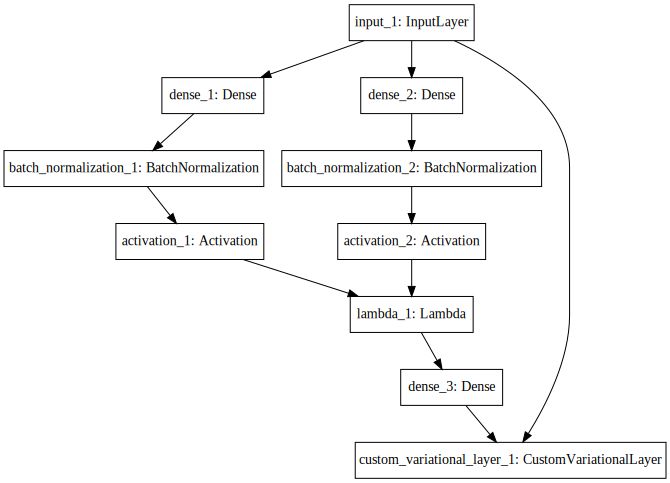

In [13]:
# Visualize the connections of the custom VAE model
output_model_file = os.path.join('figures', 'onehidden_warmup_batchnorm_vae.png')
plot_model(vae, to_file=output_model_file)

SVG(model_to_dot(vae).create(prog='dot', format='svg'))

## Train the model

The training data is shuffled after every epoch and 10% of the data is heldout for calculating validation loss.

In [14]:
%%time
hist = vae.fit(np.array(rnaseq_train_df),
               shuffle=True,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(np.array(rnaseq_test_df), np.array(rnaseq_test_df)),
               callbacks=[WarmUpCallback(beta)])

Train on 9413 samples, validate on 1046 samples
Epoch 1/50
9413/9413 [==============================] - 4s - loss: 3020.5910 - val_loss: 3143.1783
Epoch 2/50
9413/9413 [==============================] - 4s - loss: 2829.4949 - val_loss: 2833.7952
Epoch 3/50
9413/9413 [==============================] - 4s - loss: 2791.2786 - val_loss: 2799.1504
Epoch 4/50
9413/9413 [==============================] - 4s - loss: 2772.1242 - val_loss: 2786.9416
Epoch 5/50
9413/9413 [==============================] - 4s - loss: 2759.6945 - val_loss: 2771.3542
Epoch 6/50
9413/9413 [==============================] - 4s - loss: 2750.9641 - val_loss: 2750.4299
Epoch 7/50
9413/9413 [==============================] - 4s - loss: 2743.9815 - val_loss: 2745.1754
Epoch 8/50
9413/9413 [==============================] - 4s - loss: 2738.7934 - val_loss: 2742.5162
Epoch 9/50
9413/9413 [==============================] - 4s - loss: 2734.0398 - val_loss: 2737.2689
Epoch 10/50
9413/9413 [==============================] - 4s -

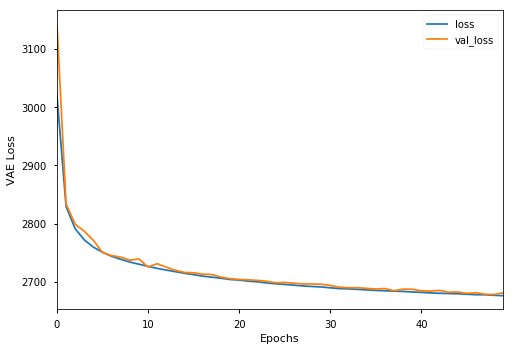

In [15]:
# Visualize training performance
history_df = pd.DataFrame(hist.history)
hist_plot_file = os.path.join('figures', 'onehidden_warmup_batchnorm.svg')
ax = history_df.plot()
ax.set_xlabel('Epochs')
ax.set_ylabel('VAE Loss')
fig = ax.get_figure()
fig.savefig(hist_plot_file)

## Compile and output trained models

We are interested in:

1. The model to encode/compress the input gene expression data
  * Can be possibly used to compress other tumors
2. The model to decode/decompress the latent space back into gene expression space
  * This is our generative model
3. The latent space compression of all pan cancer TCGA samples
  * Non-linear reduced dimension representation of tumors can be used as features for various tasks
    * Supervised learning tasks predicting specific gene inactivation events
    * Interpolating across this space to observe how gene expression changes between two cancer states
4. The weights used to compress each latent node
  * Potentially indicate learned biology differentially activating tumors

### Encoder model

In [16]:
# Model to compress input
encoder = Model(rnaseq_input, z_mean_encoded)

In [17]:
# Encode rnaseq into the hidden/latent representation - and save output
encoded_rnaseq_df = encoder.predict_on_batch(rnaseq_df)
encoded_rnaseq_df = pd.DataFrame(encoded_rnaseq_df, index=rnaseq_df.index)

encoded_rnaseq_df.columns.name = 'sample_id'
encoded_rnaseq_df.columns = encoded_rnaseq_df.columns + 1
encoded_file = os.path.join('models', 'onehidden_warmup_batchnorm.tsv')
encoded_rnaseq_df.to_csv(encoded_file, sep='\t')

In [18]:
# What are the most and least activated nodes
top_active_nodes = encoded_rnaseq_df.sum(axis=0).sort_values(ascending=False)
print(top_active_nodes.head(10))
top_active_nodes.tail(10)

sample_id
92    22457.835938
71    21948.853516
95    21566.316406
96    20561.634766
76    20312.646484
82    19855.769531
31    19647.775391
27    19642.291016
7     19581.240234
10    19555.455078
dtype: float32


sample_id
63    11147.363281
78    11026.460938
32    10941.249023
36    10926.122070
42    10875.253906
14    10805.651367
8     10704.379883
15     9136.851562
68     7844.464355
58     7409.948730
dtype: float32

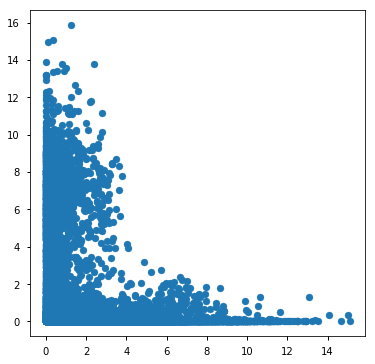

In [19]:
# Example distribution of latent layer
plt.figure(figsize=(6, 6))
plt.scatter(encoded_rnaseq_df.iloc[:, 4], encoded_rnaseq_df.iloc[:, 7])

#### Encoded representation layer also recapitulates signal identified in raw data

Perform a t-sne on the data to visualize if the latent layer recapitulates relationships observed through raw data t-sne.

In [20]:
from sklearn import manifold

tsne = manifold.TSNE(n_components=3, init='pca', random_state=0, perplexity=20,
                     learning_rate=300, n_iter=400)
tsne_out = tsne.fit_transform(encoded_rnaseq_df)
tsne_out = pd.DataFrame(tsne_out, columns=['1', '2', '3'])
tsne_out.index = encoded_rnaseq_df.index
tsne_out.index.name = 'tcga_id'
tsne_out_file = os.path.join('models', 'onehidden_warmup_batchnorm_tsne_out.tsv')
tsne_out.to_csv(tsne_out_file, sep='\t')
tsne_out.head()

,1,2,3
tcga_id,,,
TCGA-02-0047-01,13.789300,-7.939112,-2.969391
TCGA-02-0055-01,8.301288,-5.550647,-1.020993
TCGA-02-2483-01,16.265942,-8.919164,-1.453329
TCGA-02-2485-01,14.838730,-7.041953,-2.673177
TCGA-02-2486-01,12.671350,-6.479059,-0.813343


### Decoder (generative) model

In [21]:
# build a generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim, ))  # can generate from any sampled z vector
_x_decoded_mean = decoder_to_reconstruct(decoder_input)
decoder = Model(decoder_input, _x_decoded_mean)

In [22]:
# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct = decoder.predict(np.array(encoded_rnaseq_df))
input_rnaseq_reconstruct = pd.DataFrame(input_rnaseq_reconstruct, index=rnaseq_df.index,
                                        columns=rnaseq_df.columns)
input_rnaseq_reconstruct.head(3)

,RPS4Y1,XIST,KRT5,AGR2,CEACAM5,KRT6A,KRT14,CEACAM6,DDX3Y,KDM5D,...,FAM129A,C8orf48,CDK5R1,FAM81A,C13orf18,GDPD3,SMAGP,C2orf85,POU5F1B,CHST2
tcga_id,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0047-01,0.607967,0.268228,0.205705,0.047186,0.032732,0.062098,0.053772,0.050735,0.639139,0.611527,...,0.453891,0.536780,0.749142,0.676382,0.599239,0.394186,0.418983,0.562896,0.234436,0.640018
TCGA-02-0055-01,0.123437,0.600167,0.255900,0.118038,0.055252,0.156149,0.142619,0.086389,0.098334,0.073298,...,0.563861,0.558564,0.614214,0.575927,0.607690,0.362068,0.543827,0.240139,0.206170,0.652346
TCGA-02-2483-01,0.640520,0.197252,0.138103,0.047335,0.037689,0.044190,0.048368,0.051563,0.608774,0.557177,...,0.399787,0.502866,0.733129,0.575510,0.488330,0.363139,0.411724,0.492279,0.208298,0.601181


In [23]:
rnaseq_df.head(3)

,RPS4Y1,XIST,KRT5,AGR2,CEACAM5,KRT6A,KRT14,CEACAM6,DDX3Y,KDM5D,...,FAM129A,C8orf48,CDK5R1,FAM81A,C13orf18,GDPD3,SMAGP,C2orf85,POU5F1B,CHST2
tcga_id,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0047-01,0.678296,0.289910,0.034230,0.0,0.0,0.084731,0.031863,0.037709,0.746797,0.687833,...,0.440610,0.428782,0.732819,0.634340,0.580662,0.294313,0.458134,0.478219,0.168263,0.638497
TCGA-02-0055-01,0.200633,0.654917,0.181993,0.0,0.0,0.100606,0.050011,0.092586,0.103725,0.140642,...,0.620658,0.363207,0.592269,0.602755,0.610192,0.374569,0.722420,0.271356,0.160465,0.602560
TCGA-02-2483-01,0.785980,0.140842,0.081082,0.0,0.0,0.000000,0.000000,0.000000,0.730648,0.657189,...,0.437658,0.471489,0.868774,0.471141,0.487212,0.385521,0.466642,0.784059,0.160797,0.557074


## Save the encoder/decoder models for future investigation

In [24]:
encoder_model_file = os.path.join('models', 'encoder_onehidden_warmstart_batchnorm_vae.hdf5')
decoder_model_file = os.path.join('models', 'decoder_onehidden_warmstart_batchnorm_vae.hdf5')

encoder.save(encoder_model_file)
decoder.save(decoder_model_file)